In [440]:
import os
import spectral
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt

import keras

from keras.layers import Conv2D, Conv3D, Flatten, Dense, Reshape, BatchNormalization
from keras.layers import Dropout, Input
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils

### Drw Model figure---Model Visualization
from keras.utils.vis_utils import plot_model
from keras.callbacks import Callback,EarlyStopping

from operator import truediv

from plotly.offline import init_notebook_mode

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score, roc_auc_score

init_notebook_mode(connected=True) #requirement for plot

%matplotlib inline  

'''
魔法命令 %matplotlib inline  激活Matplotlib，为Ipython和Jupyter提供“内嵌后端”支持，
也就是作为一个静态图像嵌入Jupyer中，因此Matplotlib就不需要使用plt.show()来主动调用图像展示窗口
'''

'\n魔法命令 %matplotlib inline  激活Matplotlib，为Ipython和Jupyter提供“内嵌后端”支持，\n也就是作为一个静态图像嵌入Jupyer中，因此Matplotlib就不需要使用plt.show()来主动调用图像展示窗口\n'

# Data Loading

In [441]:
## GLOBAL VARIABLES
# dataset1 = 'IP'
# dataset2 = 'SA'
# dataset3 = 'PU'
dataset = 'IP'
test_ratio = 0.7
windowSize = 25

In [442]:
#Load dataset
def loadData(name):
    data_path = os.path.join(os.getcwd(),'data') #os.getcwd()
    if name == 'IP':
        data = sio.loadmat(os.path.join(data_path, 'Indian_pines_corrected.mat'))['indian_pines_corrected']
        labels = sio.loadmat(os.path.join(data_path, 'Indian_pines_gt.mat'))['indian_pines_gt']
    elif name == 'SA':
        data = sio.loadmat(os.path.join(data_path, 'Salinas_corrected.mat'))['salinas_corrected']
        labels = sio.loadmat(os.path.join(data_path, 'Salinas_gt.mat'))['salinas_gt']
    elif name == 'PU':
        data = sio.loadmat(os.path.join(data_path, 'PaviaU.mat'))['paviaU']
        labels = sio.loadmat(os.path.join(data_path, 'PaviaU_gt.mat'))['paviaU_gt']
    return data, labels

In [443]:
# Dataset split
def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test

In [444]:
### Using PCA for removing the spectral redundancy(冗余) 
### The  function for newX ???
def applyPCA(X, numComponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca

In [445]:
### Pdding zeros
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

In [446]:
### create data cube??
def createImageCubes(X, y, windowSize=5, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

In [447]:
X, y = loadData(dataset)

X.shape, y.shape

((145, 145, 200), (145, 145))

|Dataset|DataShape|LabelShape|
|:----:|:----:|:----:|
|IP|(145, 145, 200)|(145, 145)|
|SA|(512, 217, 204)|(512, 217)|
|PU|(610, 340, 103)|(610, 340)|

In [448]:
K = X.shape[2]

In [449]:
K = 30 if dataset == 'IP' else 15
X,pca = applyPCA(X,numComponents=K)
X.shape,pca

((145, 145, 30), PCA(n_components=30, whiten=True))

In [450]:
X, y = createImageCubes(X, y, windowSize=windowSize)

X.shape, y.shape

((10249, 25, 25, 30), (10249,))

In [451]:
# 3:7 Split  Train:Test st 3:7 from total data
Xtrain, Xtest, ytrain, ytest = splitTrainTestSet(X, y, test_ratio)

Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((3074, 25, 25, 30), (7175, 25, 25, 30), (3074,), (7175,))

In [452]:
# Before mode training splite to get validation
# Will not resample the validation set after each epoch
# 2:1 Split  Train:Valid split 2:1 from total Train 
Xtrain, Xvalid, ytrain, yvalid = splitTrainTestSet(Xtrain, ytrain, 0.3333)

Xtrain.shape, Xvalid.shape, ytrain.shape, yvalid.shape

((2049, 25, 25, 30), (1025, 25, 25, 30), (2049,), (1025,))

# Model and Training

In [453]:
Xtrain = Xtrain.reshape(-1, windowSize, windowSize, K, 1)
Xtrain.shape

(2049, 25, 25, 30, 1)

In [454]:
ytrain = np_utils.to_categorical(ytrain)
ytrain.shape


(2049, 16)

In [455]:
# r validition
Xvalid = Xvalid.reshape(-1, windowSize, windowSize, K, 1)
Xvalid.shape

(1025, 25, 25, 30, 1)

In [456]:
# For validation
yvalid = np_utils.to_categorical(yvalid)
yvalid.shape

(1025, 16)

In [457]:
S = windowSize
L = K
# IP SA:16
# PU:9 
output_units = 16 if (dataset == 'IP' or dataset == 'SA') else 16

In [458]:
## input layer
input_layer = Input((S, S, L, 1))
## convolutional layers
### filters---卷积核数；kernel_size---卷积核大小
conv_layer1 = Conv3D(filters=8, kernel_size=(3, 3, 7), activation='relu')(input_layer)
conv_layer2 = Conv3D(filters=16, kernel_size=(3, 3, 5), activation='relu')(conv_layer1)
conv_layer3 = Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu')(conv_layer2)

### AttributeError: 'KerasTensor' object has no attribute '_keras_shape'
### Try to use shape instead
#print(conv_layer3._keras_shape)
#conv3d_shape = conv_layer3._keras_shape

conv3d_shape = conv_layer3.shape
print("After three times convD,and before reshaping,\nKerasTensorShape:{}".format(conv3d_shape))
### conv3D-->conv2D
conv_layer3 = Reshape((conv3d_shape[1], conv3d_shape[2], conv3d_shape[3]*conv3d_shape[4]))(conv_layer3)
print("After three times convD,and before reshaping,\nKerasTensorShape:{}".format(conv_layer3.shape))

conv_layer4 = Conv2D(filters=64, kernel_size=(3,3), activation='relu')(conv_layer3)

### Flatte层:将张量扁平化，即输入一维化，不影响张量大小.
### 常在Conv层和Dense层之间过渡.
flatten_layer = Flatten()(conv_layer4)

## fully connected layers
### Dense层：全连接层.
### Dropout层：Dense层之后，防止过拟合，提高模型泛化性能.
dense_layer1 = Dense(units=256, activation='relu')(flatten_layer)
dense_layer1 = Dropout(0.4)(dense_layer1)
dense_layer2 = Dense(units=128, activation='relu')(dense_layer1)
dense_layer2 = Dropout(0.4)(dense_layer2)
output_layer = Dense(units=output_units, activation='softmax')(dense_layer2)

After three times convD,and before reshaping,
KerasTensorShape:(None, 19, 19, 18, 32)
After three times convD,and before reshaping,
KerasTensorShape:(None, 19, 19, 576)


In [459]:
# define the model with input layer and output layer
model = Model(inputs=input_layer, outputs=output_layer)

Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 25, 25, 30, 1)]   0         
_________________________________________________________________
conv3d_42 (Conv3D)           (None, 23, 23, 24, 8)     512       
_________________________________________________________________
conv3d_43 (Conv3D)           (None, 21, 21, 20, 16)    5776      
_________________________________________________________________
conv3d_44 (Conv3D)           (None, 19, 19, 18, 32)    13856     
_________________________________________________________________
reshape_14 (Reshape)         (None, 19, 19, 576)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 17, 17, 64)        331840    
_________________________________________________________________
flatten_14 (Flatten)         (None, 18496)             0  

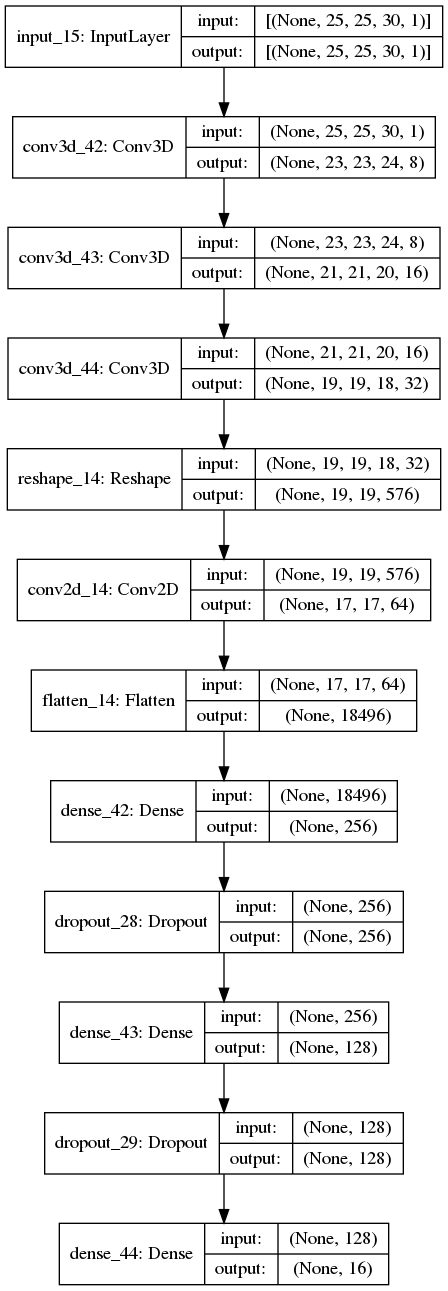

In [460]:
model.summary()

### Model Visualization
plot_model(model,to_file='ModelVisual.png',show_shapes=True)

In [461]:
# compiling the model
adam = Adam(lr=0.001, decay=1e-06)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [462]:
# checkpoint
filepath = "best-model.hdf5"
# ve_best_only mode
checkpoint = ModelCheckpoint(filepath, monitor='accuracy', verbose=1, save_best_only=True, mode='max')
#earlyStopping=EarlyStopping(monitor='accuracy',patience=15,mode=max)
earlyStopping=EarlyStopping(monitor='val_accuracy',patience=30,mode='max')
#callbacks_list = [checkpoint,MyCallback(),EarlyStopping(monitor='roc_auc', patience=20, verbose=2, mode='max')]
#callbacks_list = [checkpoint,earlyStopping]
callbacks_list = [checkpoint]

In [ ]:
###About 60 epochs to reach  acceptable accuracy.
#history = model.fit(x=Xtrain, y=ytrain, batch_size=256, epochs=200, callbacks=callbacks_list)
#history = model.fit(x=Xtrain, y=ytrain, batch_size=256, epochs=300,
                    #callbacks=callbacks_list,validation_data=(Xvalid,yvalid),validation_steps=10,validation_batch_size=64)
history = model.fit(x=Xtrain, y=ytrain, batch_size=256, epochs=100, callbacks=callbacks_list,validation_data=(Xvalid,yvalid))

Epoch 1/100
9/9 [==============================] - 25s 3s/step - loss: 2.8404 - accuracy: 0.1314 - val_loss: 2.6655 - val_accuracy: 0.2390

Epoch 00001: accuracy improved from -inf to 0.16789, saving model to best-model.hdf5
Epoch 2/100
9/9 [==============================] - 25s 3s/step - loss: 2.6197 - accuracy: 0.2347 - val_loss: 2.4106 - val_accuracy: 0.2390

In [ ]:
plt.figure(figsize=(7,7))
plt.grid()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
#plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training','Validation'], loc='upper right')
plt.savefig("loss_curve.pdf")
plt.show()

In [ ]:
plt.figure(figsize=(7,7))
plt.ylim(0,1.1)
plt.grid()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
#plt.plot(history.history['val_acc'])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training','Validation'],loc='lower right')
plt.savefig("acc_curve.pdf")
plt.show()

# Test

In [ ]:
# load best weights
model.load_weights("best-model.hdf5")
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [ ]:
Xtest = Xtest.reshape(-1, windowSize, windowSize, K, 1)
Xtest.shape

In [ ]:
ytest = np_utils.to_categorical(ytest)
ytest.shape

In [ ]:
Y_pred_test = model.predict(Xtest)
y_pred_test = np.argmax(Y_pred_test, axis=1)

classification = classification_report(np.argmax(ytest, axis=1), y_pred_test)
print(classification)

In [ ]:
def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc

In [ ]:
def reports (X_test,y_test,name):
    #start = time.time()
    Y_pred = model.predict(X_test)
    y_pred = np.argmax(Y_pred, axis=1)
    #end = time.time()
    #print(end - start)
    if name == 'IP':
        target_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn'
                        ,'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed', 
                        'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
                        'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
                        'Stone-Steel-Towers']
    elif name == 'SA':
        target_names = ['Brocoli_green_weeds_1','Brocoli_green_weeds_2','Fallow','Fallow_rough_plow','Fallow_smooth',
                        'Stubble','Celery','Grapes_untrained','Soil_vinyard_develop','Corn_senesced_green_weeds',
                        'Lettuce_romaine_4wk','Lettuce_romaine_5wk','Lettuce_romaine_6wk','Lettuce_romaine_7wk',
                        'Vinyard_untrained','Vinyard_vertical_trellis']
    elif name == 'PU':
        target_names = ['Asphalt','Meadows','Gravel','Trees', 'Painted metal sheets','Bare Soil','Bitumen',
                        'Self-Blocking Bricks','Shadows']
    
    classification = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names)
    oa = accuracy_score(np.argmax(y_test, axis=1), y_pred)
    confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    each_acc, aa = AA_andEachClassAccuracy(confusion)
    kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)
    score = model.evaluate(X_test, y_test, batch_size=32)
    Test_Loss =  score[0]*100
    Test_accuracy = score[1]*100
    
    return classification, confusion, Test_Loss, Test_accuracy, oa*100, each_acc*100, aa*100, kappa*100

In [ ]:
classification, confusion, Test_loss, Test_accuracy, oa, each_acc, aa, kappa = reports(Xtest,ytest,dataset)
classification = str(classification)
confusion = str(confusion)
file_name =dataset+"classification_report.txt"

with open(file_name, 'w') as x_file:
    x_file.write('{} Test loss (%)'.format(Test_loss))
    x_file.write('\n')
    x_file.write('{} Test accuracy (%)'.format(Test_accuracy))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{} Kappa accuracy (%)'.format(kappa))
    x_file.write('\n')
    x_file.write('{} Overall accuracy (%)'.format(oa))
    x_file.write('\n')
    x_file.write('{} Average accuracy (%)'.format(aa))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{}'.format(classification))
    x_file.write('\n')
    x_file.write('{}'.format(confusion))

In [ ]:
def Patch(data,height_index,width_index):
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]
    
    return patch

In [ ]:
# load the original image
X, y = loadData(dataset)

In [ ]:
height = y.shape[0]
width = y.shape[1]
PATCH_SIZE = windowSize
numComponents = K

In [ ]:
X,pca = applyPCA(X, numComponents=numComponents)

In [ ]:
X = padWithZeros(X, PATCH_SIZE//2)

# calculate the predicted image
outputs = np.zeros((height,width))
for i in range(height):
    for j in range(width):
        target = int(y[i,j])
        if target == 0 :
            continue
        else :
            image_patch=Patch(X,i,j)
            X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2], 1).astype('float32')                                   
            prediction = (model.predict(X_test_image))
            prediction = np.argmax(prediction, axis=1)
            outputs[i][j] = prediction+1

ground_truth = spectral.imshow(classes = y,figsize =(7,7))

predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(7,7))

spectral.save_rgb("predictions.jpg", outputs.astype(int), colors=spectral.spy_colors)

spectral.save_rgb(str(dataset)+"_ground_truth.jpg", y, colors=spectral.spy_colors)